# C-MAPSS Aircraft Engine RUL Prediction

En los últimos años, dentro del campo de la Gestión de Activos Físicos, diversas investigaciones han propuesto la utilización de modelos de deep learning cada vez más sofisticados para la estimación y predicción del tiempo de vida remanente (RUL) de equipos y/o componentes particulares. El tiempo de vida remanente o Remaining Useful Life (RUL) consiste en una variable utilizada principalmente para describir la degradación temporal de un activo durante su operación y describe el tiempo de operación remanente del activo antes de que ocurra su falla. De este modo, mejores estimadores de esta variable resultan de suma importancia a la hora de gestionar e implementar mejores políticas de mantenimiento y operación.

  <img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/tarea_03/bin/scatter_rul.png" height="200"> <img src="https://www.researchgate.net/profile/Xiaolei_Fang/publication/310789705/figure/fig2/AS:462413100261377@1487259282977/Simplified-diagram-of-engine-simulated-in-C-MAPSS-6.png" height="200">

El Comercial Modular Aero-Propulsion System Simulation (C-MAPSS) es un software desarrollado por NASA como ambiente de simulación de motores de reacción tipo turbofán. Así, esta herramienta permite la implementación y evaluación de algoritmos de control y diagnóstico sobre la operación de un motor turbofán de 90.000 lbf de propulsión.

A diferencia de los workshops del curso, en esta tarea trabajarán con los datasets `CMAPSS_FD001_raw.npz` y `CMAPSS_FD004_raw.npz`. Estos datasets ya han sido procesados para extraer las ventanas de datos de cada una de las simulaciones. No obstante, los datos esta vez no se encuentran normalizados, por lo que procuren utilizar `MinMaxScaler` previo al entrenamiento de sus modelos.

    Dataset FD001
    - Condiciones Operacionales: 1
    - Modos de Falla: 1
    - Simulaciones de Entrenamiento: 100
    - Simulaciones de Testing: 100
    - Timesteps: 30
    - Sensors: 19

    Dataset FD004
    - Condiciones Operacionales: 6
    - Modos de Falla: 2
    - Simulaciones de Entrenamiento: 249
    - Simulaciones de Testing: 237
    - Timesteps: 30
    - Sensors: 19

Cada uno de los datasets cuenta con los conjuntos `X_train`, `Y_train`, `X_test` e `Y_test`, previamente definidos. Similar al dataset utilizado en los workshops, estos conjuntos presentan las ventanas de datos separadas por simulación. Recuerden utilizar `np.vstack` y `np.reshape` para reestructurar los arreglos a una forma compatible con las estructuras y capas de `keras`.

Para facilitar la carga de los archivos a un entorno de Google Colab, los archivos han sido cargados a un Google Drive. Copien el siguiente bloque de código en su Notebook para ejecutar la rutina de descarga. Los archivos serán cargados en el directorio `\content\datasets`.

In [1]:
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# inicializar GoogleDrive con credenciales de autorización
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# crear carpeta para descargar los archivos .npz
!mkdir /content/datasets

# Google Drive IDs para descargar los archivos .npz
files_id = [('CMAPSS_FD001_raw.npz', '1ZcYauNQs_-QZMndP2THq6tQ53M6aWZJb'),
            ('CMAPSS_FD004_raw.npz', '1lbGpuYZFGjmcu-xiE1ehsqlhPC4S2cWN')]

# comenzar descarga
print('descargando datasets: ', end='')

for filename, id in files_id:
  save_path = os.path.join('/content/datasets', filename)

  # descargar y guardar en /content/datasets
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(save_path)

# indicar descarga terminada
print('done')

mkdir: cannot create directory ‘/content/datasets’: File exists
descargando datasets: done


In [2]:
import numpy as np

# cargar archivo npz
dataset = np.load('/content/datasets/CMAPSS_FD001_raw.npz', allow_pickle=True)

# sacar conjunto X_train
X_train = dataset['X_train']
Y_train = dataset['Y_train']
X_test = dataset['X_test']
Y_test = dataset['Y_test']

# print npz keys
print( list( dataset.keys() ) )

['X_train', 'Y_train', 'X_test', 'Y_test']


## Formato de Entrega

Los entregables de esta tarea son los siguientes.
- Jupyter Notebook (.ipynb): Todo el procesamiento de la tarea debe estar contenido en un único Notebook. Considere este archivo como un informe de metodología donde se reporten todos los pasos y bloques de código utilizados para resolver el problema. **Sea ordenado**; utilice comentarios en su código y bloques de texto para mejorar la legibilidad del Notebook.

- Reporte Resultados (.pdf): Este archivo debe contener los resultados obtenidos en su tarea, junto con un análisis correspondiente. Considere este documento como la sección de Resultados y Análisis de la tarea. En este sentido, debe mantener un formato de informe estándar.

## Exploración de los datos

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

De este análisis de las distribuciones de los datos de entrenamiento y test, se puede ver que ambos tienen el mismo contenido de información, por lo que si se entrena correctamente un método de regresión o clasificación en el dataset de entrenamiento, se debería tener un buen desempeño en el conjunto de test.

Para realizar un análisis más completo, se debería hacer un análisis de correlación de estas varibles con la variable a predecir, para determinar si es que a partir de las variables con las que se cuenta, se puede de alguna forma obtener información para las predicciones.

In [4]:
def processData(dataset):

    # sacar conjunto X_train
    print('cargar datos')
    X_train = dataset['X_train']
    Y_train = dataset['Y_train']
    X_test = dataset['X_test']
    Y_test = dataset['Y_test']
    
    # se stackean las simulaciones de entrenamiento
    print('stackear datos')
    X_train_ = np.vstack(X_train)
    Y_train = np.vstack(Y_train)
    X_test_ = np.vstack(X_test)
    Y_test = np.vstack(Y_test)

    n_features = X_train_.shape[2]
    mantener = []

    print('sacar datos constantes')
    for col in range(n_features):
        try:
            std = np.std(X_train_[:,:,col].reshape(-1,1))
            if std > 0:
                mantener.append(col)
        except:
            print('a sacar col ', col)

    mantener = np.array(mantener)
    print('se mantienen ', mantener)

    print(X_train_.shape)

    X_train_ = np.stack([x[:,mantener] for x in X_train_ ])
    X_test_ = np.stack([x[:,mantener] for x in X_test_ ])

    print(X_train_.shape)
    n_features = X_train_.shape[2]

    # explorar distribuciones de datos de entrenamiento
    fig, axs = plt.subplots(2, n_features, figsize=(28,4),
                            constrained_layout=True)

    fig.suptitle('sensors histogram', fontsize=24)
    for sensor in range(n_features):
        axs[0,sensor].hist(X_train_[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
        axs[0,sensor].set_title(sensor)
        axs[1,sensor].hist(X_test_[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
    
    plt.show()

    print('reescalando datos')

    X_train_ = X_train_.reshape(-1, n_features)
    X_test_ = X_test_.reshape(-1, n_features)
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_train = scaler.fit_transform(X_train_).reshape(-1,30, n_features)
    X_test = scaler.transform(X_test_).reshape(-1,30, n_features)

    # explorar distribuciones de datos de entrenamiento
    fig, axs = plt.subplots(2, n_features, figsize=(28,4),
                            sharex='col', sharey='col',
                            constrained_layout=True)

    fig.suptitle('sensors histogram', fontsize=24)
    for sensor in range(n_features):
        axs[0,sensor].hist(X_train[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
        axs[0,sensor].set_title(sensor)
        axs[1,sensor].hist(X_test[:,:,sensor].reshape(-1,1),
                          density=True, color='skyblue', ec='skyblue', bins=50)
    
    plt.show()

    return X_train, Y_train, X_test, Y_test

In [5]:
# ----------------------------------------------------------------------------
def plot_loss_function(train_info, figsize=(5,5)):
    """
    -> None
    
    this function plots de evolution of the loss function of the model 
    during the training epochs.
    
    :param train_info:
        training history of the classification model.
        
    """
    # crear figura
    plt.figure(figsize=figsize)
    
    plt.plot(train_info.history['loss'])
    plt.plot(train_info.history['val_loss'])
    
    # caracteristicas del plot
    plt.title('Model loss')
    plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
 
# ----------------------------------------------------------------------------

In [6]:
from matplotlib import cm
# ----------------------------------------------------------------------------    
def plot_predict_scatter(Y_true, Y_pred, eps=0.05, figsize=(12, 5), title='', **kargs):
    """
    -> None
    
    Plotea la disperción entre Y_true e Y_pred (este último correspondiente
    a la predicción realizada por el modelo) con el fin de visualizar el 
    desempeño del modelo.
    
    :param DataFrame Y_true:
        set de datos reales con los cuales comparar las estimaciones.
    :param DataFrame Y_pred:
        set de datos obtenidos con el modelo.
    :param float eps:
        radio que determina la vecindad de los puntos.
    :param str title:
        titulo a poner en el plot.
        
    :returns:
        None
    """
    
    # reordenar datos
    Y_true = np.array(Y_true).flatten()
    Y_pred = np.array(Y_pred).flatten()
    
    # calcular densidad
    z = np.zeros_like(Y_true)
    
    for i in range( Y_true.shape[0] ):
        # distancia
        dist = np.sqrt( (Y_true[i] - Y_true)**2 + (Y_pred[i] - Y_pred)**2 )
        # cantidad de vecinos
        z[i] = np.sum( dist < eps )
        
    # ordenar datos
    idx = np.argsort(z)
    Y_true, Y_pred, z = Y_true[idx], Y_pred[idx], z[idx]
    
    # obtener colores
    cmap = cm.get_cmap('jet')
    z_min, z_max = np.min(z), np.max(z)
    
    colors = cmap( (z - z_min)/(z_max - z_min) )
    
    # inicializar plot
    fig = plt.figure(figsize=figsize)
    
    # plotear Y_true vs Y_pred
    plt.scatter(Y_true, Y_pred, c=colors,**kargs)
    
    # plotear linea 1:1
    plt.plot([0, 300], [0, 300], c='k')
    
    # añadir limites
    plt.xlim([0, 300])
    plt.ylim([0, 300])
    
    #plt.title(title)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.show()
    return None

# ----------------------------------------------------------------------------  

In [7]:

# ----------------------------------------------------------------------------    
def plot_RUL_scatter(Y_true, Y_pred, eps=0.05, figsize=(12, 5), title='', **kargs):
    """
    -> None
    
    Plotea la disperción entre Y_true e Y_pred (este último correspondiente
    a la predicción realizada por el modelo) con el fin de visualizar el 
    desempeño del modelo para estimar el RUL de la turbina.
    
    :param DataFrame Y_true:
        set de datos reales con los cuales comparar las estimaciones.
    :param DataFrame Y_pred:
        set de datos obtenidos con el modelo.
    :param float eps:
        radio que determina la vecindad de los puntos.
    :param str title:
        titulo a poner en el plot.
        
    :returns:
        None
    """
    
    # reordenar datos
    Y_true = np.array(Y_true).flatten()
    Y_pred = np.array(Y_pred).flatten()
    
    # calcular densidad
    z = np.zeros_like(Y_true)
    
    for i in range( Y_true.shape[0] ):
        # distancia
        dist = np.sqrt( (Y_true[i] - Y_true)**2 + (Y_pred[i] - Y_pred)**2 )
        # cantidad de vecinos
        z[i] = np.sum( dist < eps )
        
    # ordenar datos
    idx = np.argsort(z)
    Y_true, Y_pred, z = Y_true[idx], Y_pred[idx], z[idx]
    
    # obtener colores
    cmap = cm.get_cmap('jet')
    z_min, z_max = np.min(z), np.max(z)
    
    colors = cmap( (z - z_min)/(z_max - z_min) )
    
    # inicializar plot
    fig = plt.figure(figsize=figsize)
    
    # plotear Y_true vs Y_pred
    plt.scatter(Y_true, Y_pred, c=colors,**kargs)
    
    # obtener máximos y mínimos
    pred_min, pred_max = np.min(Y_pred), np.max(Y_pred)
    true_min, true_max = np.min(Y_true), np.max(Y_true)
    
    # plotear linea 1:1
    plt.plot([true_min, true_max], [pred_min, pred_max], c='k')
    
    # añadir limites
    plt.xlim([true_min, true_max])
    plt.ylim([pred_min, pred_max])
    
    #plt.title(title)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.show()
    return None


cargar datos
stackear datos
sacar datos constantes
se mantienen  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 17 18]
(17731, 30, 19)
(17731, 30, 17)


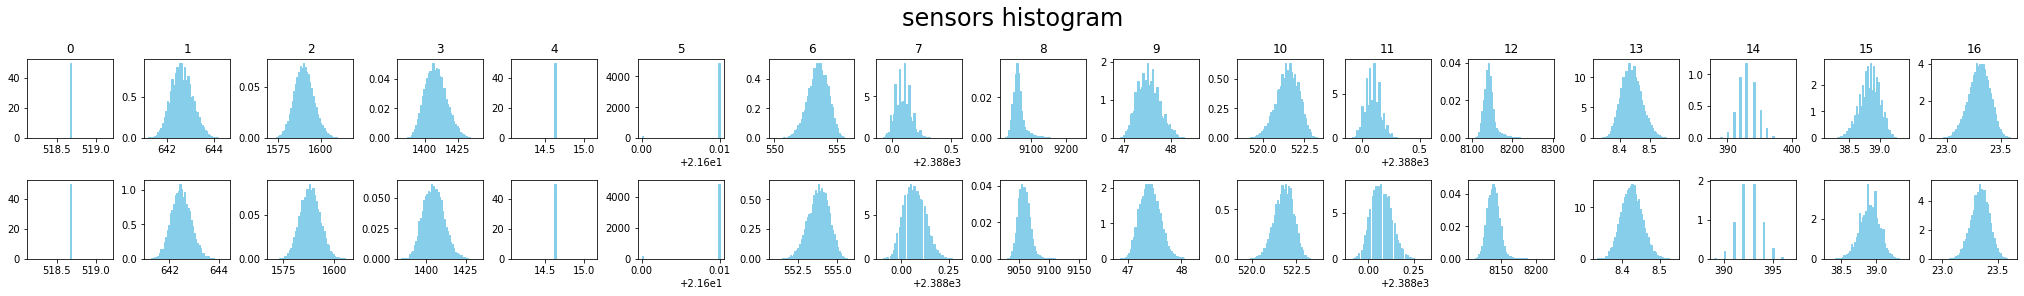

reescalando datos


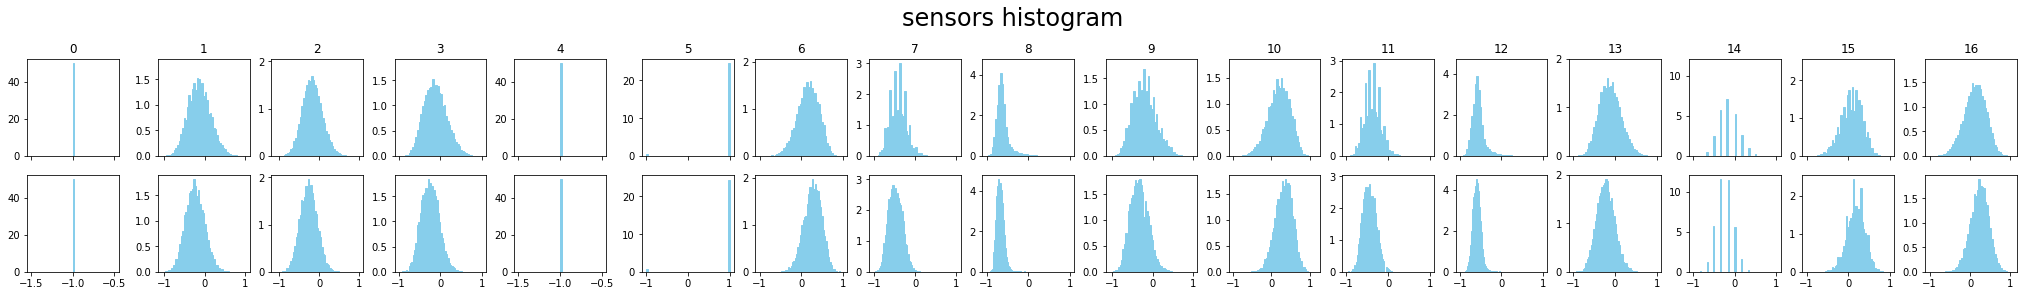

In [10]:
X_train, Y_train, X_test, Y_test = processData(dataset)

n_features = X_train.shape[2]


## 1. Recurrent Models FD001

Para el dataset `FD001` deben implementar y entrenar dos modelos de pronóstico de RUL, utilizando capas RNN y LSTM, respectivamente.

Recuerden que este problema de pronóstico consiste en un problema de regresión, por lo que como se vio en clases, deben utilizar el `mean squared error` como métrica de evaluación y función de pérdida.

Ajusten los hiperparámetros de sus modelos tipo RNN y LSTM para reducir el `mse` sobre un conjunto de validación `(X_val, Y_val)` que deberán generar a partir de las simulaciones de entrenamiento. Luego, para cada modelo reporten:

- RMSE sobre conjunto de testing y tiempo de entrenamiento para tres (3) iteraciones de entrenamiento, junto con sus promedios.

Discutan sobre las diferencias a nivel de desempeño y tiempo de entrenamiento que se observan entre ambos tipos de redes. Fundamenten en base a la estructura teórica de estas celdas recurrentes.

Comenten sobre si en este caso se justifica el uso de capas LSTM.

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Input

from keras.layers import SimpleRNN as RNN
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers

from keras.optimizers import Adam


In [11]:
# RNN

# inicializar modelo keras.Sequential
model = Sequential()

input_dim = ( 30, n_features )
model.add( Input( shape=input_dim ) )

model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( Dropout(rate=0.1) )
model.add( RNN(32, activation='relu', return_sequences=True ) )
model.add( RNN(32, activation='relu', return_sequences=True ) )

model.add( Flatten() )
model.add( Dropout(rate=0.2) )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=1, activation='linear') )

opt = Adam( learning_rate=1e-3 )

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 64)            5248      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 30, 64)            8256      
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 30, 32)            3104      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 960)              

In [12]:
def train(model, X_train, Y_train, X_test, Y_test, epochs):
    # realizar data splitting
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                      test_size=0.2,
                                                      random_state=0)

    # print sample distribution
    print( 'train split: {:d} samples'.format(X_train.shape[0]) )
    print( '\nvalidation split: {:d} samples'.format(X_val.shape[0]) )
    # realizar rutina de entrenamiento
    model_history = model.fit(X_train, Y_train,
                              batch_size=128, epochs=epochs,
                              validation_data=(X_val, Y_val))

    # plot gráfico de función de pérdida
    plot_loss_function(model_history, figsize=(10,4))
    
    # obtener predicciones de X_test del modelo
    Y_pred = model.predict( X_val )

    # obtener valores RUL reales del X_test
    Y_true = Y_val

    # calcular el rmse de las predicciones.
    rmse = np.sqrt( np.mean( np.power( Y_pred - Y_true, 2 ), axis=None ) )
    print('validation rmse: {:1.3f}'.format(rmse))

    # plot de matriz de confusión
    plot_RUL_scatter(Y_true, Y_pred, eps=15)

    # obtener predicciones de X_test del modelo
    Y_pred = model.predict( X_test )

    # obtener valores RUL reales del X_test
    Y_true = Y_test

    # calcular el rmse de las predicciones.
    rmse = np.sqrt( np.mean( np.power( Y_pred - Y_true, 2 ), axis=None ) )
    print('testing rmse: {:1.3f}'.format(rmse))

    # plot de matriz de confusión
    plot_RUL_scatter(Y_true, Y_pred, eps=15)

train split: 14184 samples

validation split: 3547 samples
Epoch 1/10
111/111 [==============================] - 6s 52ms/step - loss: 2738.0613 - mae: 37.7754 - val_loss: 1506.5802 - val_mae: 28.0692
Epoch 2/10
111/111 [==============================] - 5s 47ms/step - loss: 1500.7028 - mae: 27.6340 - val_loss: 1496.0151 - val_mae: 26.6897
Epoch 3/10
111/111 [==============================] - 5s 48ms/step - loss: 1325.2261 - mae: 25.5327 - val_loss: 1173.4252 - val_mae: 23.8300
Epoch 4/10
111/111 [==============================] - 5s 47ms/step - loss: 1181.7170 - mae: 23.8240 - val_loss: 1345.1315 - val_mae: 22.9981
Epoch 5/10
111/111 [==============================] - 5s 47ms/step - loss: 1142.7137 - mae: 23.5004 - val_loss: 1027.4868 - val_mae: 21.7383
Epoch 6/10
111/111 [==============================] - 5s 47ms/step - loss: 1072.3235 - mae: 22.7167 - val_loss: 1006.7261 - val_mae: 22.3156
Epoch 7/10
111/111 [==============================] - 5s 47ms/step - loss: 1040.4456 - mae: 22.

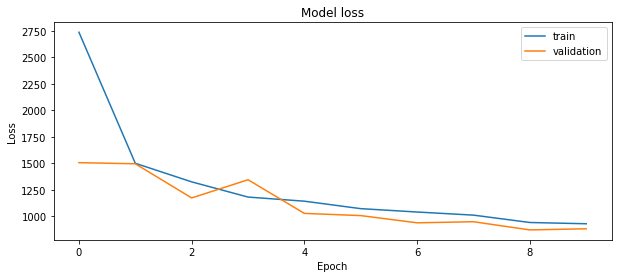

validation rmse: 29.703


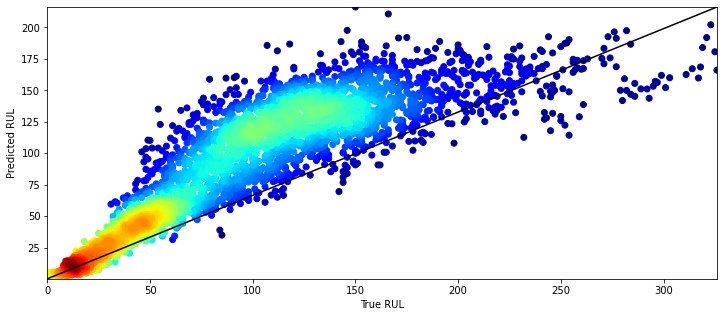

testing rmse: 68.807


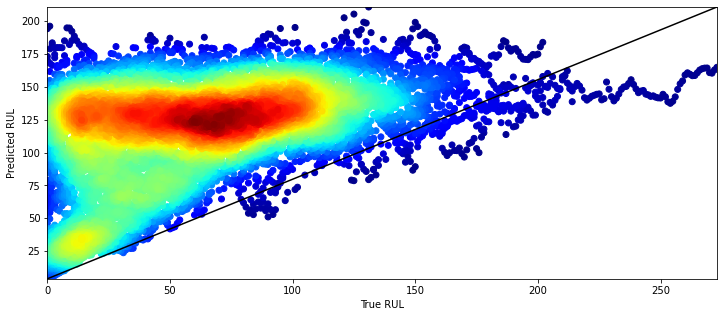

In [14]:
train(model, X_train, Y_train, X_test, Y_test, 10)

In [15]:
# LSTM

model = Sequential()
input_dim = ( 30, n_features )
model.add( Input( shape=input_dim ) )

model.add( LSTM(64, activation='relu', return_sequences=True ) )
model.add( LSTM(64, activation='relu', return_sequences=True ) )

model.add( Dropout(rate=0.1) )

model.add( LSTM(32, activation='relu', return_sequences=True ) )
model.add( LSTM(32, activation='relu', return_sequences=True ) )

model.add( Flatten() )
model.add( Dropout(rate=0.2) )

model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=1, activation='linear') )

opt = Adam( learning_rate=1e-3 )

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            20992     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 32)            12416     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 960)              

train split: 14184 samples

validation split: 3547 samples
Epoch 1/10
111/111 [==============================] - 14s 129ms/step - loss: 3778.8997 - mae: 43.6933 - val_loss: 1600.1885 - val_mae: 28.9478
Epoch 2/10
111/111 [==============================] - 13s 119ms/step - loss: 1649.1146 - mae: 29.4748 - val_loss: 1581.3755 - val_mae: 27.7580
Epoch 3/10
111/111 [==============================] - 13s 120ms/step - loss: 1542.2379 - mae: 28.2347 - val_loss: 1339.2349 - val_mae: 26.2283
Epoch 4/10
111/111 [==============================] - 13s 121ms/step - loss: 1364.7847 - mae: 26.3526 - val_loss: 1203.9060 - val_mae: 24.7032
Epoch 5/10
111/111 [==============================] - 13s 121ms/step - loss: 1250.2894 - mae: 25.0653 - val_loss: 1361.3444 - val_mae: 24.0665
Epoch 6/10
111/111 [==============================] - 14s 126ms/step - loss: 1156.8030 - mae: 23.9736 - val_loss: 1076.6086 - val_mae: 22.8755
Epoch 7/10
111/111 [==============================] - 13s 120ms/step - loss: 1124.5

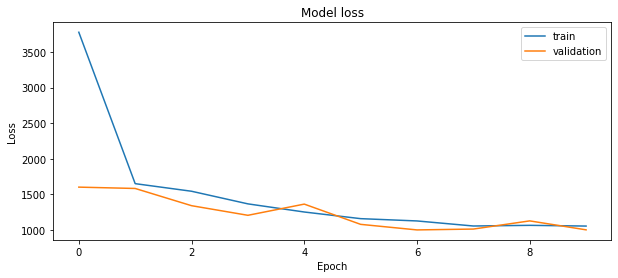

validation rmse: 31.615


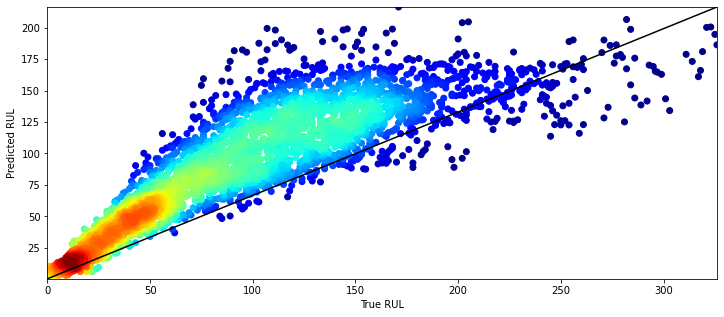

testing rmse: 66.862


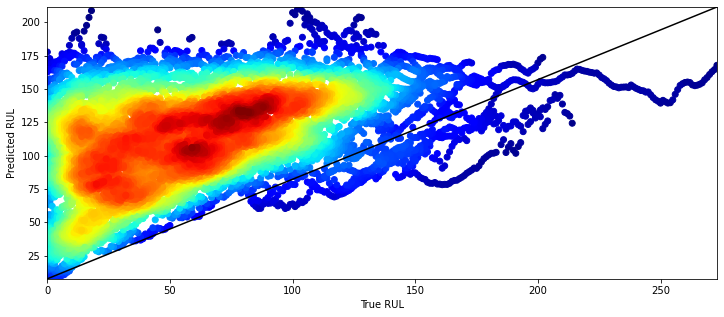

In [17]:
train(model, X_train, Y_train, X_test, Y_test, 10)

## 2. Recurrent Models FD004

Utilizando la mejor arquitectura desarrollada en la sección anterior (sin cambiar sus hiperparámetros), entrenen el modelo sobre el dataset `FD004`. Luego, reporten:
- Utilizando las funciones `plot_RUL_scatter` y `plot_RUL_sorted` disponibles en el módulo `utils` del github del curso, grafiquen el desempeño del modelo sobre los conjuntos de testing de los datasets `FD001` y `FD004`.
- RMSE sobre el conjunto de testing de cada dataset para tres (3) iteraciones de entrenamiento, junto con sus promedios.

Comparen los resultados obtenidos sobre el dataset `FD004` con los observados en `FD001`, discutan sobre las diferencias a nivel de desempeño.

In [18]:
# cargar archivo npz
dataset = np.load('/content/datasets/CMAPSS_FD004_raw.npz', allow_pickle=True)

cargar datos
stackear datos
sacar datos constantes
se mantienen  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
(54028, 30, 19)
(54028, 30, 19)


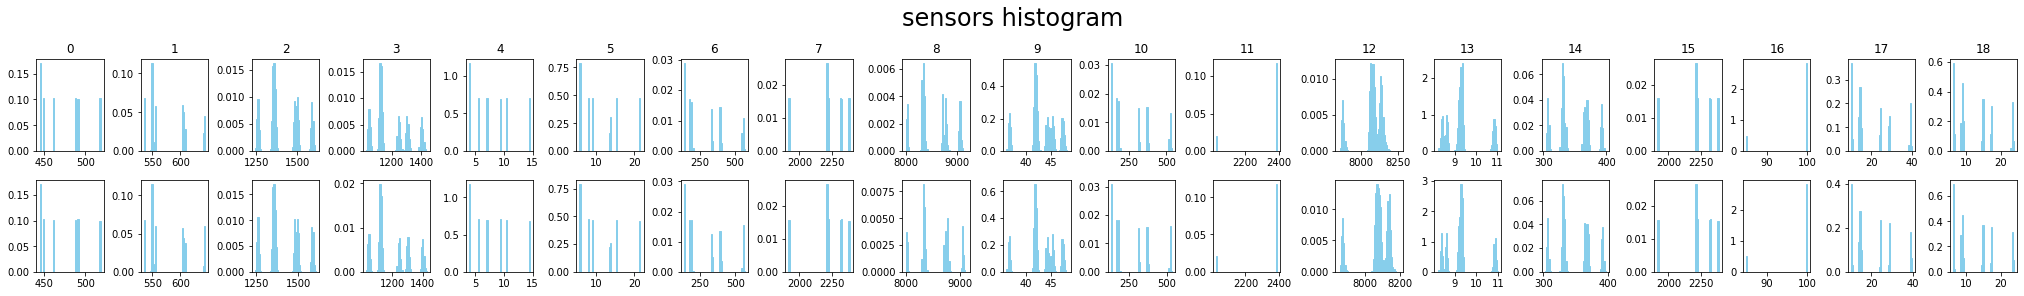

reescalando datos


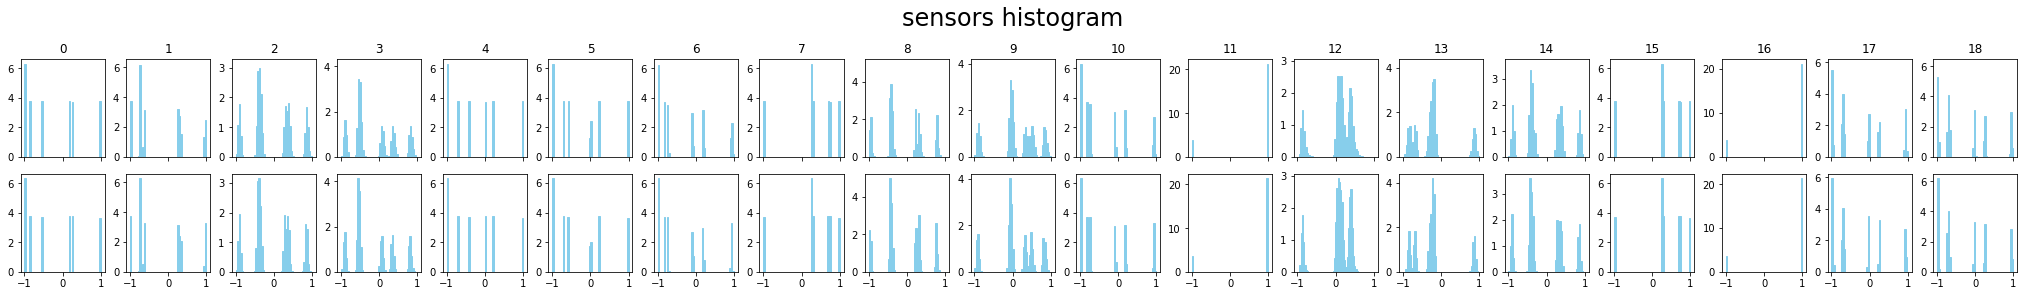

In [19]:
X_train, Y_train, X_test, Y_test = processData(dataset)

n_features = X_train.shape[2]


In [20]:
# RNN

# inicializar modelo keras.Sequential
model = Sequential()

input_dim = ( 30, n_features )
model.add( Input( shape=input_dim ) )

model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( Dropout(rate=0.1) )
model.add( RNN(32, activation='relu', return_sequences=True ) )
model.add( RNN(32, activation='relu', return_sequences=True ) )

model.add( Flatten() )
model.add( Dropout(rate=0.2) )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=1, activation='linear') )

opt = Adam( learning_rate=1e-3 )

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 30, 64)            5376      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 30, 64)            8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 30, 32)            3104      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 30, 32)            2080      
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 960)              

train split: 43222 samples

validation split: 10806 samples
Epoch 1/10
338/338 [==============================] - 17s 49ms/step - loss: 5580.3223 - mae: 56.9733 - val_loss: 3571.7202 - val_mae: 43.2160
Epoch 2/10
338/338 [==============================] - 16s 48ms/step - loss: 3462.2366 - mae: 43.7629 - val_loss: 3366.6140 - val_mae: 41.0822
Epoch 3/10
338/338 [==============================] - 16s 47ms/step - loss: 3046.7424 - mae: 40.7842 - val_loss: 2602.0366 - val_mae: 37.2054
Epoch 4/10
338/338 [==============================] - 16s 48ms/step - loss: 2640.5676 - mae: 37.9302 - val_loss: 2367.3108 - val_mae: 34.5910
Epoch 5/10
338/338 [==============================] - 16s 48ms/step - loss: 2195.0891 - mae: 34.5871 - val_loss: 1846.0920 - val_mae: 31.3805
Epoch 6/10
338/338 [==============================] - 16s 48ms/step - loss: 1665.3462 - mae: 30.2130 - val_loss: 1436.3300 - val_mae: 28.5338
Epoch 7/10
338/338 [==============================] - 16s 48ms/step - loss: 1383.7899 - 

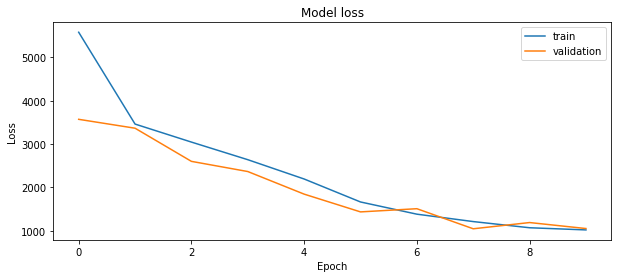

validation rmse: 32.444


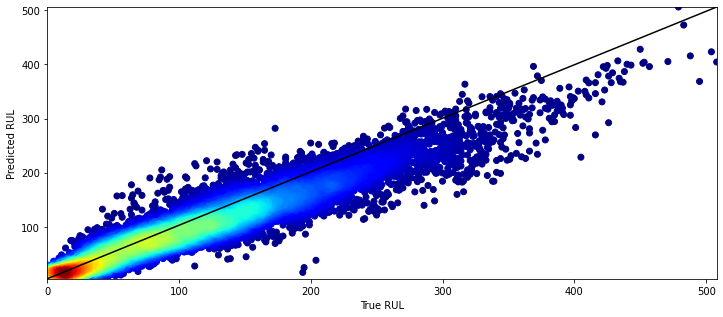

testing rmse: 84.108


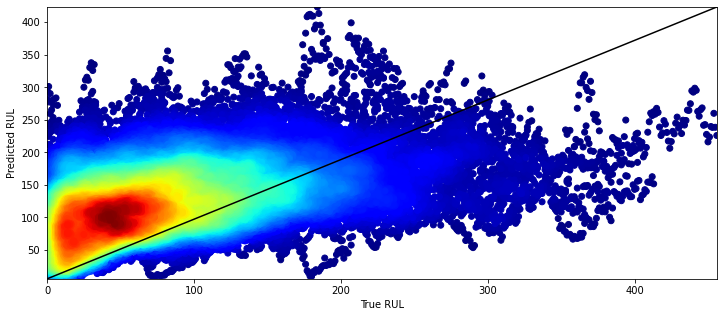

In [21]:
train(model, X_train, Y_train, X_test, Y_test, 10)

## 3. Convolutional and Recurrent Model
Utilizando la mejor arquitectura desarrolla en la primera sección y el dataset `FD001`, incorporen en la red una etapa de preprocesamiento convolucional que alimentará a la etapa recurrente de su modelo. En particular, noten que las ventanas temporales al ser de la forma `(n_timesteps, n_features)` pueden ser interpretadas como imágenes de un solo canal. De este modo, consideren:
- Utilicen `np.reshape` para reestructurar los conjuntos `X_train` y `X_test` de modo que sean compatibles con la estructura `Conv2D` de `keras`.
- Para conectar los `feature maps` resultantes de la etapa convolucional con la etapa recurrente deben utilizar la capa `TimeDistributed( Flatten() )` de `keras`. Pueden encontrar información sobre esta estructura en la documentación.

La idea es que con este preprocesamiento mejoren las métricas sobre el conjunto de evaluación. Una vez entrenado su modelo de predicción, reporten:
- Arquitectura Conv2D-RNN/LSTM utilizada.
- RMSE sobre el conjunto de testing para tres (3) iteraciones de entrenamiento, junto con su promedio.

In [25]:
# reshape los datos de entrada
X_train_ = X_train.reshape(-1, 30, n_features, 1)
X_test_ = X_test.reshape(-1, 30, n_features, 1)
print(X_train_.shape, X_test_.shape)

(54028, 30, 19, 1) (34081, 30, 19, 1)


In [33]:
# creacion de red convolucional

# inicializar modelo keras.Sequential
model = Sequential()

input_dim = ( 30, n_features , 1)
model.add( Input( shape=input_dim ) )

model.add( layers.Conv2D(32,3, activation='relu') )
model.add( layers.Conv2D(32,3, activation='relu') )
model.add( layers.TimeDistributed( Flatten() ))
model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( RNN(64, activation='relu', return_sequences=True ) )
model.add( Dropout(rate=0.1) )
model.add( RNN(32, activation='relu', return_sequences=True ) )
model.add( RNN(32, activation='relu', return_sequences=True ) )

model.add( Flatten() )
model.add( Dropout(rate=0.2) )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=96, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=64, activation='relu') )
model.add( Dense(units=1, activation='linear') )

opt = Adam( learning_rate=1e-3 )

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 17, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 15, 32)        9248      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 26, 480)           0         
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 26, 64)            34880     
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 26, 64)            8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 26, 64)            0         
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 26, 32)          

In [ ]:
train(model, X_train_, Y_train, X_test_, Y_test, 10)

train split: 43222 samples

validation split: 10806 samples
Epoch 1/10
338/338 [==============================] - 67s 197ms/step - loss: 5616.9189 - mae: 57.3912 - val_loss: 3590.7529 - val_mae: 46.7641
Epoch 2/10
338/338 [==============================] - 65s 192ms/step - loss: 3631.0479 - mae: 44.7595 - val_loss: 3729.0908 - val_mae: 49.2278
Epoch 3/10
338/338 [==============================] - 66s 194ms/step - loss: 3347.4133 - mae: 42.8345 - val_loss: 3630.2812 - val_mae: 42.2472
Epoch 4/10
338/338 [==============================] - 65s 193ms/step - loss: 3094.7122 - mae: 40.9249 - val_loss: 2782.3875 - val_mae: 38.5196
Epoch 5/10
338/338 [==============================] - 65s 193ms/step - loss: 2786.8469 - mae: 38.7159 - val_loss: 2406.4778 - val_mae: 35.5023
Epoch 6/10
338/338 [==============================] - 67s 197ms/step - loss: 2323.5979 - mae: 35.4873 - val_loss: 2266.9529 - val_mae: 34.1441
Epoch 7/10
107/338 [========>.....................] - ETA: 41s - loss: 2070.7087 -